## EDA and Classify using Embeddings

In [5]:
import pandas as pd
from utils import drug_data_tools

In [3]:
drug_classes = pd.read_csv("outputs/drug-classes.csv", index_col=0)#, index_col="Drug Name")
drug_classes

,Drug Class
Drug Name,
ella,Progesterone receptor modulators
pancreatin,Digestive enzymes
boroleum,Topical rubefacient
benicar,Angiotensin receptor blockers
duac,Topical acne agents
...,...
acne-10-gel-topical,Topical acne agents
lorbrena,Multikinase inhibitors
halcion,Benzodiazepines


In [8]:
selected_molecules = drug_data_tools.get_selected_molecules()
selected_molecules[:10]

['amoxicillin',
 'metoprolol',
 'phenoxymethylpenicillin',
 'azithromycin',
 'celiprolol',
 'simvastatin',
 'vancomycin',
 'ibuprofen',
 'tadalafil',
 'timolol']

In [9]:
# Drugs that are both in Drugs.com and Selected Molecules
len(set(drug_classes.index).intersection(selected_molecules))

115

In [10]:
# How many drugs.com drugs are also in Selected Molecules
intersecting_drugs = drug_classes[drug_classes.index.isin(set(drug_classes.index).intersection(selected_molecules))]
# intersecting_drugs

In [ ]:
intersecting_drugs['Drug Class'].value_counts()

Drug Class
Multikinase inhibitors                                 18
Statins                                                 7
Protease inhibitors                                     6
Angiotensin receptor blockers                           6
Local injectable anesthetics                            5
Cardioselective beta blockers                           5
Antibiotics / antineoplastics                           4
Purine nucleosides                                      4
BCR-ABL tyrosine kinase inhibitors                      4
EGFR inhibitors                                         4
Miscellaneous antivirals                                4
Macrolides                                              3
Heparins                                                3
Ophthalmic glaucoma agents                              3
Non-cardioselective beta blockers                       3
Integrase strand transfer inhibitor                     3
Nonsteroidal anti-inflammatory drugs                    3
Nuc

In [ ]:
# Nr unique drug classes
len(set(intersecting_drugs['Drug Class']))

37

In [47]:
class_counts = intersecting_drugs["Drug Class"].value_counts()

# Filter out classes with less than 3 drugs in them
intersecting_drugs = intersecting_drugs[~intersecting_drugs['Drug Class'].isin(class_counts[class_counts < 3].index)]

intersecting_drugs

,Drug Class
Drug Name,
pentostatin,Antibiotics / antineoplastics
atenolol,Cardioselective beta blockers
ceritinib,Multikinase inhibitors
fedratinib,Multikinase inhibitors
ganciclovir,Purine nucleosides
...,...
irbesartan,Angiotensin receptor blockers
osimertinib,EGFR inhibitors
rosuvastatin,Statins


In [48]:
# Nr unique drug classes after filtering
len(set(intersecting_drugs['Drug Class']))

19

In [53]:
df_embeddings = pd.read_csv("outputs/llama-embeddings.csv", index_col=0)

In [54]:
# TODO Why are some drugs missing? 115 vs 103
intersecting_drugs_w_embd_df = df_embeddings.loc[df_embeddings.index.intersection(set(intersecting_drugs.index))]
intersecting_drugs_w_embd_df

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Drug Name,,,,,,,,,,,,,,,,,,,,,
candesartan,0.846399,-1.726462,0.906651,-1.306898,0.193972,0.240104,0.303152,-1.743013,-1.192302,-1.672895,...,0.621502,-0.167140,0.252433,0.113513,-1.079827,-0.638547,1.297506,0.620969,0.505722,-1.139408
pemigatinib,1.657495,-1.523324,0.316984,0.202013,-0.703365,0.021658,-1.032712,-1.622851,0.565182,-2.019764,...,0.295195,-0.309789,-1.277183,0.816564,-0.307367,1.484333,0.583064,0.173681,-1.643754,0.549972
telmisartan,1.801593,-2.129047,0.749666,-0.453170,0.827487,-0.062932,0.020983,-0.774632,-0.643007,-2.144073,...,0.582292,0.434012,0.108160,0.781245,-1.225841,0.251356,0.407616,0.496148,0.615039,-1.151465
fluvastatin,1.884299,-1.708703,1.452643,-3.322976,0.765282,0.389487,1.642352,-0.425322,-0.315836,-1.930144,...,-0.278033,-0.646324,0.640017,0.383189,-0.533273,-2.756398,1.953617,-1.458458,-0.056362,0.846975
timolol,0.890981,0.249803,0.248478,-4.084130,-1.118151,-1.208403,-0.428501,-1.777971,-1.568435,-1.088311,...,0.160558,1.121780,1.416765,0.484948,-2.007886,1.017432,-0.415180,0.877130,0.167825,-0.651065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nilotinib,1.601887,-1.431789,0.930513,-0.039980,-0.114913,0.170020,-0.495912,-0.666444,0.297700,-1.711444,...,-0.162860,-0.389524,-0.343951,0.675022,0.365671,1.148861,-0.634807,0.387918,-1.746806,0.730049
sofosbuvir,0.019505,0.669670,-2.041065,-2.784205,0.027118,0.313708,1.415276,-2.556959,-0.927886,0.875131,...,-0.203469,1.499896,0.643817,3.036791,0.464148,2.561702,0.132109,-0.862448,-2.124450,0.070136
darunavir,0.206294,-0.861255,-1.311981,-0.856387,2.775300,0.372177,2.384961,-0.891477,-0.670463,-0.338599,...,-0.455320,2.972468,1.895652,1.195464,-0.460290,2.032736,-2.124213,1.353184,-2.773972,-1.118577


In [56]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

t_sneezed_data = tsne.fit_transform(intersecting_drugs_w_embd_df)

print(type(t_sneezed_data))
print(t_sneezed_data.shape)

<class 'numpy.ndarray'>
(82, 2)


In [57]:
t_sneezed_data = pd.DataFrame(t_sneezed_data, index=intersecting_drugs_w_embd_df.index)
t_sneezed_data.head()

,0,1
Drug Name,,
candesartan,-0.827371,4.252997
pemigatinib,0.101720,9.112262
telmisartan,-0.296108,4.021256
fluvastatin,1.711032,4.466427
timolol,-3.106806,5.487944


In [60]:
t_sneezed_data_classes = pd.concat([pd.DataFrame(t_sneezed_data, index=intersecting_drugs_w_embd_df.index), intersecting_drugs.loc[intersecting_drugs_w_embd_df.index]['Drug Class']], axis=1)
t_sneezed_data_classes

,0,1,Drug Class
Drug Name,,,
candesartan,-0.827371,4.252997,Angiotensin receptor blockers
pemigatinib,0.101720,9.112262,Multikinase inhibitors
telmisartan,-0.296108,4.021256,Angiotensin receptor blockers
fluvastatin,1.711032,4.466427,Statins
timolol,-3.106806,5.487944,Non-cardioselective beta blockers
...,...,...,...
nilotinib,1.271659,8.390484,BCR-ABL tyrosine kinase inhibitors
sofosbuvir,-3.542443,0.106678,Miscellaneous antivirals
darunavir,-2.589403,-0.139922,Protease inhibitors


In [70]:
t_sneezed_data_classes['Drug Class']

Drug Name
candesartan           Angiotensin receptor blockers
pemigatinib                  Multikinase inhibitors
telmisartan           Angiotensin receptor blockers
fluvastatin                                 Statins
timolol           Non-cardioselective beta blockers
                               ...                 
nilotinib        BCR-ABL tyrosine kinase inhibitors
sofosbuvir                 Miscellaneous antivirals
darunavir                       Protease inhibitors
pentostatin           Antibiotics / antineoplastics
ketoprofen     Nonsteroidal anti-inflammatory drugs
Name: Drug Class, Length: 82, dtype: object

In [73]:
t_sneezed_data_classes['Drug Class'] = pd.Series(t_sneezed_data_classes['Drug Class'], dtype="category")

In [80]:
t_sneezed_data_classes.head()

,0,1,Drug Class
Drug Name,,,
candesartan,-0.827371,4.252997,Angiotensin receptor blockers
pemigatinib,0.101720,9.112262,Multikinase inhibitors
telmisartan,-0.296108,4.021256,Angiotensin receptor blockers
fluvastatin,1.711032,4.466427,Statins
timolol,-3.106806,5.487944,Non-cardioselective beta blockers


In [79]:
t_sneezed_data_classes.dtypes

0              float32
1              float32
Drug Class    category
dtype: object

In [84]:
t_sneezed_data_classes['Drug Class'].shape

(82,)

In [86]:
t_sneezed_data_classes.iloc[:, 0].shape

(82,)

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_4719/971416311.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


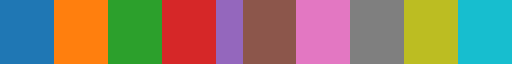

In [88]:
from matplotlib import pyplot as plt
import seaborn as sns


classes = t_sneezed_data_classes['Drug Class'].unique()
colors = plt.cm.get_cmap('tab10', len(classes))

colors

In [95]:
color_map = {c: colors(i) for i, c in enumerate(classes)}

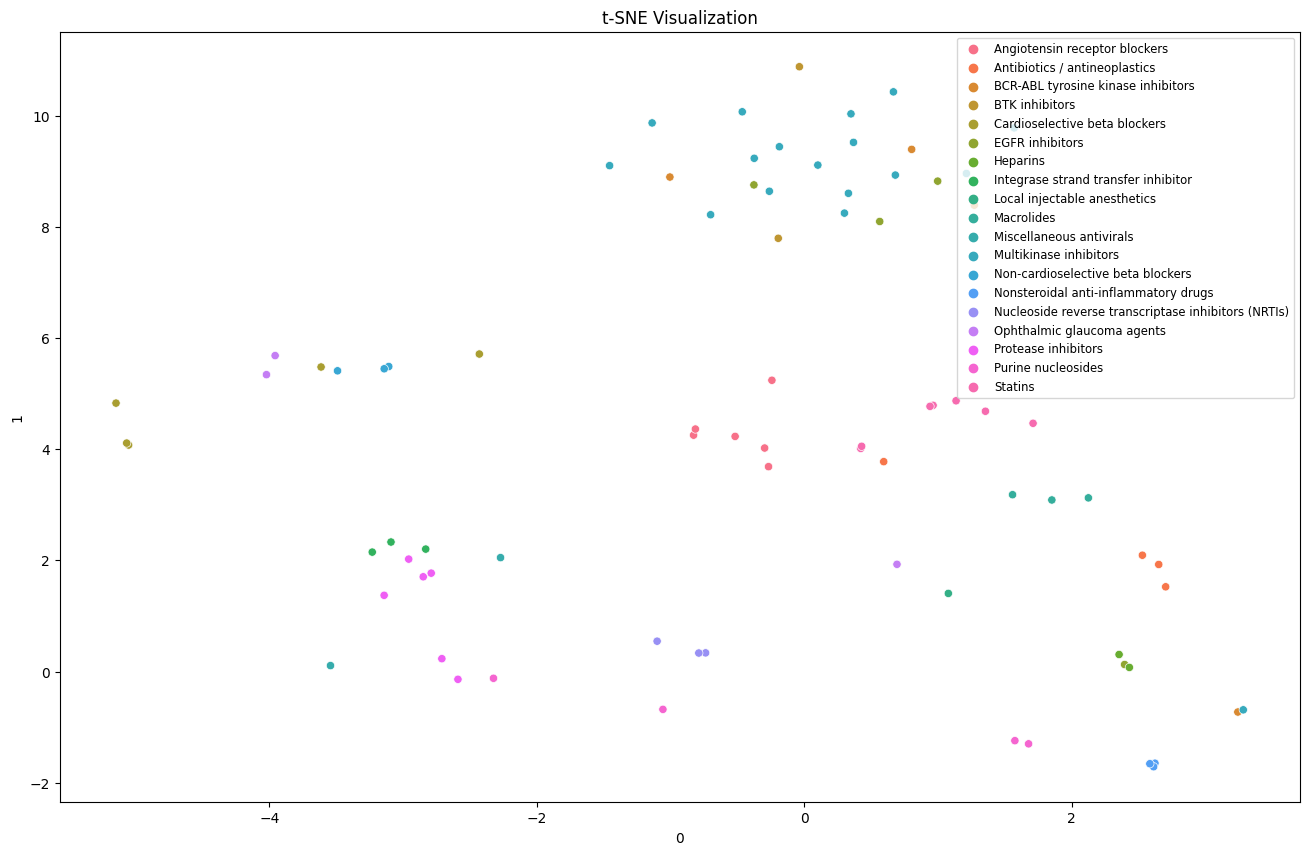

In [103]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=t_sneezed_data_classes.reset_index(drop=True), x=0, y=1, hue='Drug Class')


plt.title('t-SNE Visualization')
plt.legend(fontsize='small')
plt.show()